In [24]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy, read_and_prepare_data
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from tqdm import tqdm

In [25]:
model_name = 'A3TGCN_20231214185627.pt'
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5

In [26]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5


In [27]:
for node, df in loader._df_measurments.groupby("node_id"):
    #if node == 0:
    #get index of voltade column
        df11 = df
        voltage_ind = df.drop(columns=["date_time", "node_id"]).columns.get_loc("voltage") 
        display(df.columns)
        print(voltage_ind)
        break

Index(['node_id', 'power_production', 'power_consumption', 'PMO', 'TR',
       'junction', 'date_time', 'voltage', 'temperature_2m', 'snow_depth',
       'cloud_cover', 'is_day', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance', 'active_power',
       'reactive_power', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos'],
      dtype='object')

5


In [28]:
df11.head()

,node_id,power_production,power_consumption,PMO,TR,junction,date_time,voltage,temperature_2m,snow_depth,...,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:00:00,0.871501,-0.087913,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.000000,1.000000
1,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:15:00,0.837781,-0.099327,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.327195,0.944957
2,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:30:00,0.977922,-0.110742,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.618370,0.785887
3,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:45:00,0.581175,-0.122156,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.841471,0.540302
4,0,-0.669711,-0.211164,0,1,0,2021-06-01 01:00:00,0.501061,-0.133570,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.043465,0.999055,0.000000,1.000000


In [31]:
class TemporalLSTMGNN(torch.nn.Module):
    def __init__(self,node_features, periods):
        super(TemporalLSTMGNN, self).__init__()

        out_channels= 32
        K = 5 # size of Chebyshev filter
        self.recurrent_1 = GConvLSTM(
            in_channels=node_features, 
            out_channels=out_channels, 
            K=K, normalization='sym', 
            bias=False)

        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, timesteps, edge_index):

        h1, c1 = None, None
        for x in timesteps:
            h1, c1 = self.recurrent_1(x, edge_index, H=h1, C=c1)
            #h2, c2 = self.recurrent_2(h1, edge_index, H=h2, C=c2)

        x = F.relu(h1)
        x = self.linear(x)

        return x
    

In [32]:
#read saved model
device = torch.device('cpu')
model = TemporalLSTMGNN(node_features=loader.num_features, periods=num_timesteps_out).to(device)
model.load_state_dict(torch.load(f"../models/{model_name}", map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
import matplotlib.pyplot as plt

In [34]:
voltage_std = loader.mean_and_std["measurements"][1]["voltage"]

In [35]:
node = 50

In [36]:
preds = []
ys = []
model.eval()
with torch.no_grad():
    for snapshot_j in tqdm(eval_dataset, desc="Evaluating"):
        snapshot = loader.get_snapshot(snapshot_j)
        snapshot = snapshot.to(device)

        x = snapshot.x.permute(2,0,1)
        pred = model(x, snapshot.edge_index)
        pred = pred.detach().numpy()
        y = snapshot.y.detach().numpy()
        
        ys.append(y[node, 0]*voltage_std)
        preds.append(pred[node, 0]*voltage_std)


Evaluating: 100%|██████████| 1440/1440 [03:33<00:00,  6.76it/s]


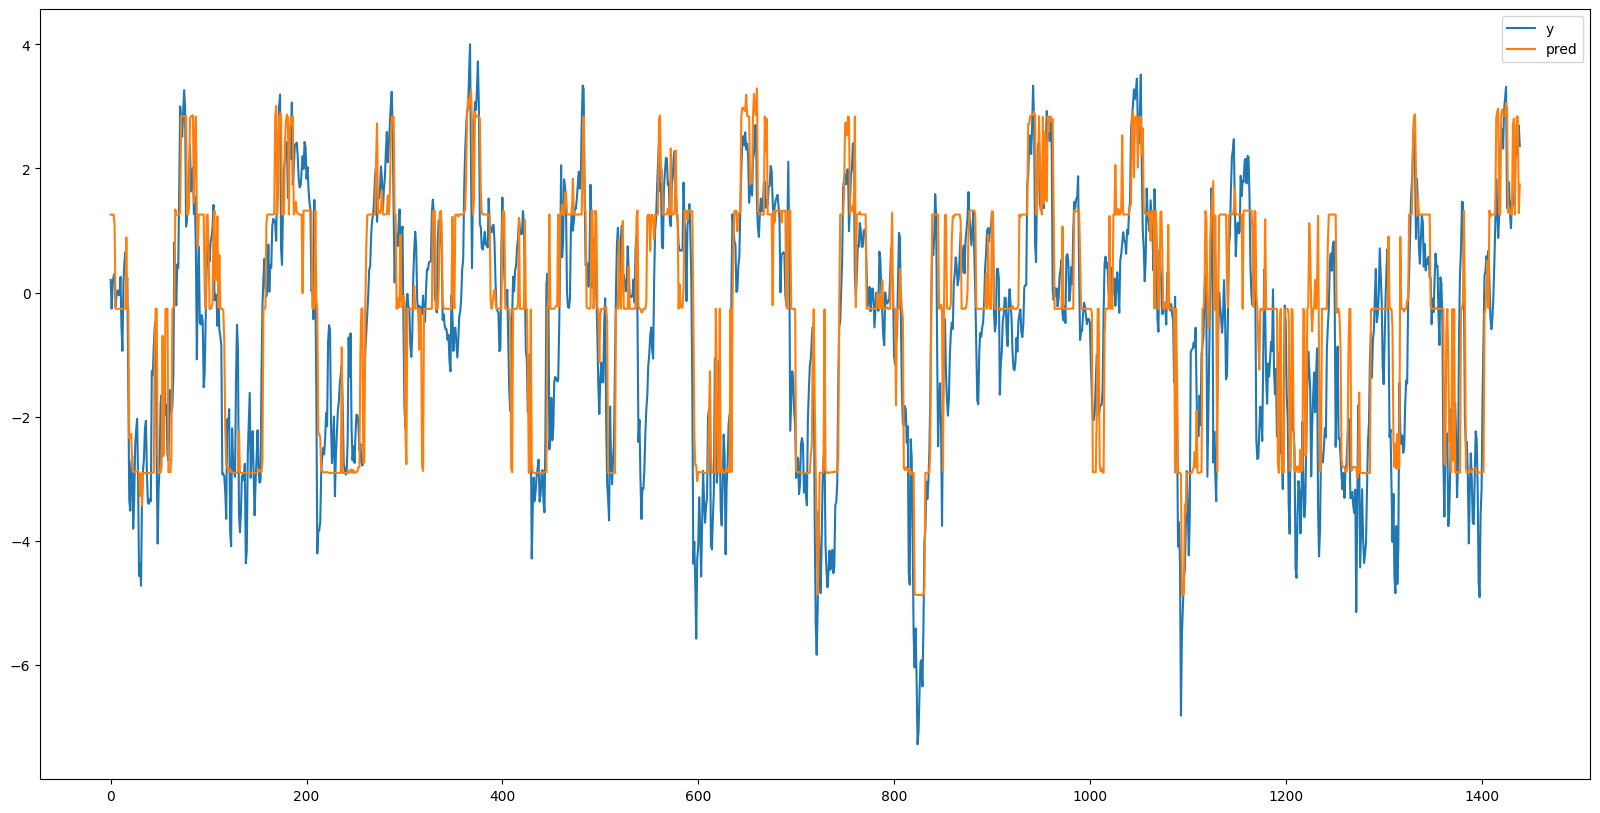

In [38]:
start = 0
end = 1440
#make bigger plot
plt.figure(figsize=(20, 10))
plt.plot(ys[start:end], label="y")
plt.plot(preds[start:end], label="pred")
plt.legend()

In [16]:
dataset = eval_dataset
ind = 1000
x = dataset[ind].x
edge_index = dataset[ind].edge_index
y = dataset[ind].y
node = 1
voltage = 5
x[node, voltage, :]


tensor([-0.5023, -0.6390, -0.5246, -0.3343, -0.4017, -0.2966, -0.2304, -0.0868,
         0.1335,  0.0817,  0.0073, -0.1487])

In [17]:
model.eval()
with torch.no_grad():
    pred = model(x, edge_index)
pred_node = pred[node, :]
plt.plot(pred_node*voltage_std, label="pred")
plt.plot(y[node, :]*voltage_std, label="y")
plt.legend()

RuntimeError: index 94 is out of bounds for dimension 0 with size 26